In [411]:
import pandas as pd
from matplotlib import pyplot as plt
from datetime import timedelta
import numpy.random as random
import numpy as np
import seaborn as sns
plt.style.use('seaborn')
%matplotlib inline

# Analysis of Cycling Data

## Loading Data

The first dataset is an export of my ride data from [Strava](https://strava.com/), an online social 
network site for cycling and other sports.  This data is a log of every ride since the start of 2018
and contains summary data like the distance and average speed.  It was exported using 
the script `stravaget.py` which uses the stravalib module to read data. Some details of
the fields exported by that script can be seen in [the documentation for stravalib](https://pythonhosted.org/stravalib/api.html#stravalib.model.Activity). 

The exported data is a CSV file so that's easy to read, however the date information in the file is 
recorded in a different timezone (UTC) so we need to do a bit of conversion.  In reading the data I'm
setting the index of the data frame to be the datetime of the ride. 

In [351]:
strava = pd.read_csv('data/strava_export.csv', index_col='date', parse_dates=True)
strava.index = strava.index.tz_convert('Australia/Sydney')
strava.head()

,average_heartrate,average_temp,average_watts,device_watts,distance,elapsed_time,elevation_gain,kudos,moving_time,workout_type
date,,,,,,,,,,
2018-01-03 07:47:51+11:00,100.6,21.0,73.8,False,15.2,94,316.00 m,10,73,Ride
2018-01-04 12:36:53+11:00,NaN,24.0,131.7,False,18.0,52,236.00 m,5,46,Ride
2018-01-04 13:56:00+11:00,83.1,25.0,13.8,False,0.0,3,0.00 m,2,2,Ride
2018-01-04 16:37:04+11:00,110.1,24.0,113.6,False,22.9,77,246.00 m,8,64,Ride
2018-01-06 06:22:46+11:00,110.9,20.0,147.7,True,58.4,189,676.00 m,12,144,Ride


The second dataset comes from an application called [GoldenCheetah](https://www.goldencheetah.org/) which provides
some analytics services over ride data.  This has some of the same fields but adds a lot of analysis of the 
power, speed and heart rate data in each ride.  This data overlaps with the Strava data but doesn't include all 
of the same rides. 

Again we create an index using the datetime for each ride, this time combining two columns in the data (date and time) 
and localising to Sydney so that the times match those for the Strava data. 

In [352]:
cheetah = pd.read_csv('data/cheetah.csv', skipinitialspace=True)
cheetah.index = pd.to_datetime(cheetah['date'] + ' ' + cheetah['time'])
cheetah.index = cheetah.index.tz_localize('Australia/Sydney')
cheetah.head()

,date,time,filename,axPower,aPower Relative Intensity,aBikeScore,Skiba aVI,aPower Response Index,aIsoPower,aIF,...,Rest AVNN,Rest SDNN,Rest rMSSD,Rest PNN50,Rest LF,Rest HF,HRV Recovery Points,NP,IF,TSS
2018-01-28 06:39:49+11:00,01/28/18,06:39:49,2018_01_28_06_39_49.json,202.211,0.75452,16.6520,1.31920,1.67755,223.621,0.83441,...,0,0,0,0,0,0,0,222.856,0.83155,20.2257
2018-01-28 07:01:32+11:00,01/28/18,07:01:32,2018_01_28_07_01_32.json,226.039,0.84343,80.2669,1.21137,1.54250,246.185,0.91860,...,0,0,0,0,0,0,0,245.365,0.91554,94.5787
2018-02-01 08:13:34+11:00,02/01/18,08:13:34,2018_02_01_08_13_34.json,0.000,0.00000,0.0000,0.00000,0.00000,0.000,0.00000,...,0,0,0,0,0,0,0,0.000,0.00000,0.0000
2018-02-06 08:06:42+11:00,02/06/18,08:06:42,2018_02_06_08_06_42.json,221.672,0.82714,78.8866,1.35775,1.86002,254.409,0.94929,...,0,0,0,0,0,0,0,253.702,0.94665,98.3269
2018-02-07 17:59:05+11:00,02/07/18,17:59:05,2018_02_07_17_59_05.json,218.211,0.81422,159.4590,1.47188,1.74658,233.780,0.87231,...,0,0,0,0,0,0,0,232.644,0.86808,171.0780


Once you have read the two datasets into the corresponding dataframes, the next step is checking the size of the initial datasets. 
The dataset derived from strava contains 268 records and 10 colums, while the dataset from cheetah has 251 observations and 362 colums.

In [353]:
print('Strava dataset contains',strava.shape[0],'rows and',strava.shape[1],'columns')
print('Cheetah dataset contains',cheetah.shape[0],'rows and',cheetah.shape[1],'columns')

Strava dataset contains 268 rows and 10 columns
Cheetah dataset contains 251 rows and 362 columns


The definitions of some of the more important fields in the data are explained in the readme file.

## Your Tasks

Your first task is to combine these two data frames using the [`join` method of Pandas](https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html#joining-on-index).   The goal is to keep only those rows of data 
that appear in __both__ data frames so that we have complete data for every row.  

In [354]:
cd=cheetah.join(strava,how='inner')
print('The combined dataset now contains',cd.shape[0],'rows and',cd.shape[1],'columns')


The combined dataset now contains 243 rows and 372 columns


# Required Analysis

1)Remove rides with no measured power (where device_watts is False) - these are commutes or MTB rides

In [355]:
drop_indexes=cd[cd['device_watts']==False].index
cd.drop(drop_indexes,inplace=True)
print('The dataset with no measured power now contains',cd.shape[0],'rows and',cd.shape[1],'columns')

The dataset with no measured power now contains 209 rows and 372 columns


2)Look at the distributions of some key variables: time, distance, average speed, average power, TSS. Are they normally distributed? Skewed?

Before looking at the distribution of this variables, I create a smaller dataset in order to include those variables that will be useful for future analysis. In addition, since 'average speed' is not in the original dataset we manually calculate this quantity (average speed is in km/h).

In [372]:
cd['average_speed']=cd['distance']/(cd['moving_time']/60)
df=cd[['Distance','moving_time','average_speed','average_heartrate','average_watts','NP','TSS','workout_type']]
print('The reduced dataset contains',df.shape[0],'rows and',df.shape[1],'columns')

The reduced dataset contains 209 rows and 8 columns


# DATA ANALYSYS

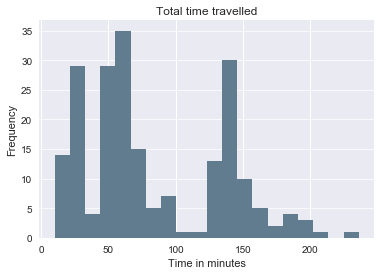

In [373]:
#TIME -> 'moving_time'
df['moving_time'].plot.hist(grid=True,color='#607c8e',rwidth=1,bins=20)
plt.title('Total time travelled')
plt.xlabel('Time in minutes')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)


It looks that the variable 'moving_time' is a multimodal distribution.By looking at the graph, it is possible to see at least 3 peaks around 20,60 and 140 minutes. In addition, a possible outlier can be identified in the right hand side of the graph (after 200 minutes).

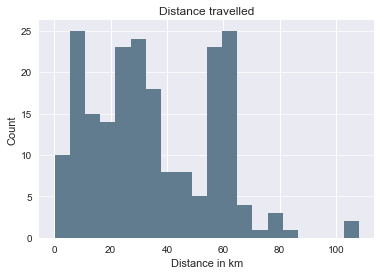

In [374]:
#DISTANCE -> 'distance'
df['Distance'].plot.hist(grid=True,color='#607c8e',rwidth=1,bins=20)
plt.title('Distance travelled')
plt.xlabel('Distance in km')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.75)

Similar consideration can be made for the distance. Once again, the distrubution is multimodal with peaks at 10,30 and 60 km. Some outliers can be identified in the right hand side of the graph (around 100 km).

Text(0.5, 1.0, 'Average_speed')

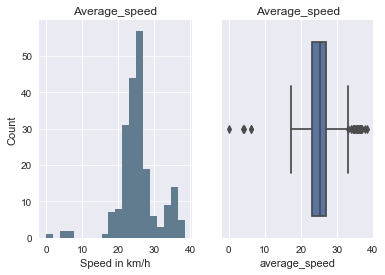

In [375]:
#SPEED -> 'average_speed'
plt.subplot(1, 2, 1)
df['average_speed'].plot.hist(grid=True,color='#607c8e',rwidth=1,bins=20)
plt.title('Average_speed')
plt.xlabel('Speed in km/h')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.75)
plt.subplot(1, 2, 2)
sns.boxplot(df["average_speed"] )
plt.title('Average_speed')

The distribution of speed looks reasonably normal distributed.However, for a better interpretation and visualization I am going to show this distribution without the outliers. Outliers can be easily visualized thank to the boxplot. According to that, we can see that some data points sit outside the fences. In fact, there are some unusual small values such as 0km/h and unusual large values around 35km/h.

Text(0, 0.5, 'Count')

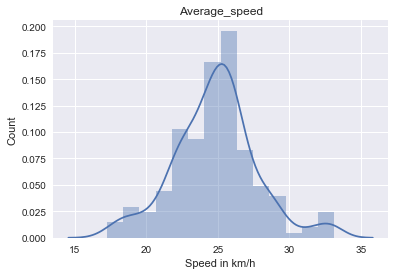

In [376]:
IQR=np.percentile(df.average_speed, 75) - np.percentile(df.average_speed, 25) 
fence_low  = np.percentile(df.average_speed, 25) -1.5*IQR
fence_high = np.percentile(df.average_speed, 75) +1.5*IQR
df_in = df.loc[(df['average_speed'] > fence_low) & (df['average_speed'] < fence_high)]
#df_in['average_speed'].plot.hist(grid=True,color='#607c8e',rwidth=1,bins=20)
sns.distplot(df_in.average_speed, kde=True);
plt.title('Average_speed')
plt.xlabel('Speed in km/h')
plt.ylabel('Count')

After removing the outliers, the distribution of 'Average_speed' looks normally distributed with an average speed around 25km/h. This can be confirmed by calculating the mean value of the "cleaned" dataset. 

In [377]:
df_in['average_speed'].mean()

24.812099637502033

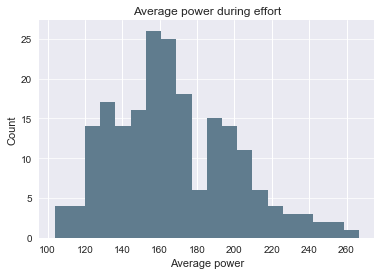

In [378]:
#POWER -> 'average power'
df['average_watts'].plot.hist(grid=True,color='#607c8e',rwidth=1,bins=20)
plt.title('Average power during effort')
plt.xlabel('Average power')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.75)

It looks that the variable 'average_watts' is a multimodal distribution.By looking at the graph, it is possible to see at least 3 peaks around 130,160 and 190.Since the distribution is multimodal, no assumption of normal distribution can be made.

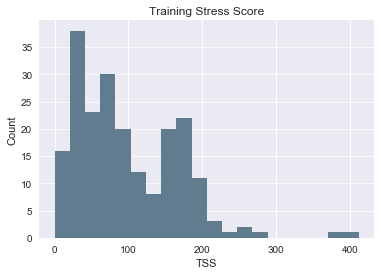

In [379]:
#Training Stress Score -> 'TSS'
df['TSS'].plot.hist(grid=True,color='#607c8e',rwidth=1,bins=20)
plt.title('Training Stress Score')
plt.xlabel('TSS')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.75)

According to his definition, Training Stress Score® (TSS) is a way of measuring how much stress is put on the body from a ride.By looking at the graph, the majority of the rides recorded a TSS below 200 which means that the recovery time after the ride will be within a day. The distribution is not symmetric (skewed to the right). In this case the mean is higher than the median even because the right hand side outliers (around 400) influence the mean and make it larger.
Values higher than 300 mean that the cyclist needs at least two days after ride to fully recover.

3)Explore the relationships between the following variables. Are any of them correlated with each other (do they vary together in a predictable way)? Can you explain any relationships you observe?
    * Distance
    * Moving Time
    * Average Speed 
    * Heart Rate
    * Power (watts)
    * Normalised power (NP)
    * Training Stress Score
    
In order to see if there are any correlations between these variables we first create a correlation matrix and then create a scatterplot matrix to better visualize these relations 

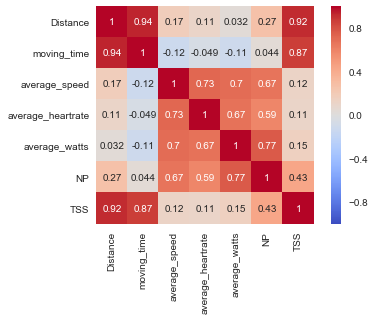

In [380]:
corrmat=df.corr()
sns.heatmap(corrmat,vmin=-1, vmax=1, square= True,annot=True,cmap='coolwarm')

Cells with dark red colour and dark blue color shown a strong linear relations. In particular, red colour displays positive linear relation while blue colour shows negative linear relations between variables.
Quite perfect positive linear relations are seen for example for distance and moving time. This is quite obvious in fact as the distance increases the time increases too.
Distance and TSS are strongly related as well (0.92).This was expected to since the TSS is a composite number that takes into account the duration and intensity of a workout to arrive at a single estimate of the overall training load and physiological stress created by that training session. 
Finally, no strong negative linear relation are shown by the correlation matrix. 

/Users/Francesco/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/Francesco/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


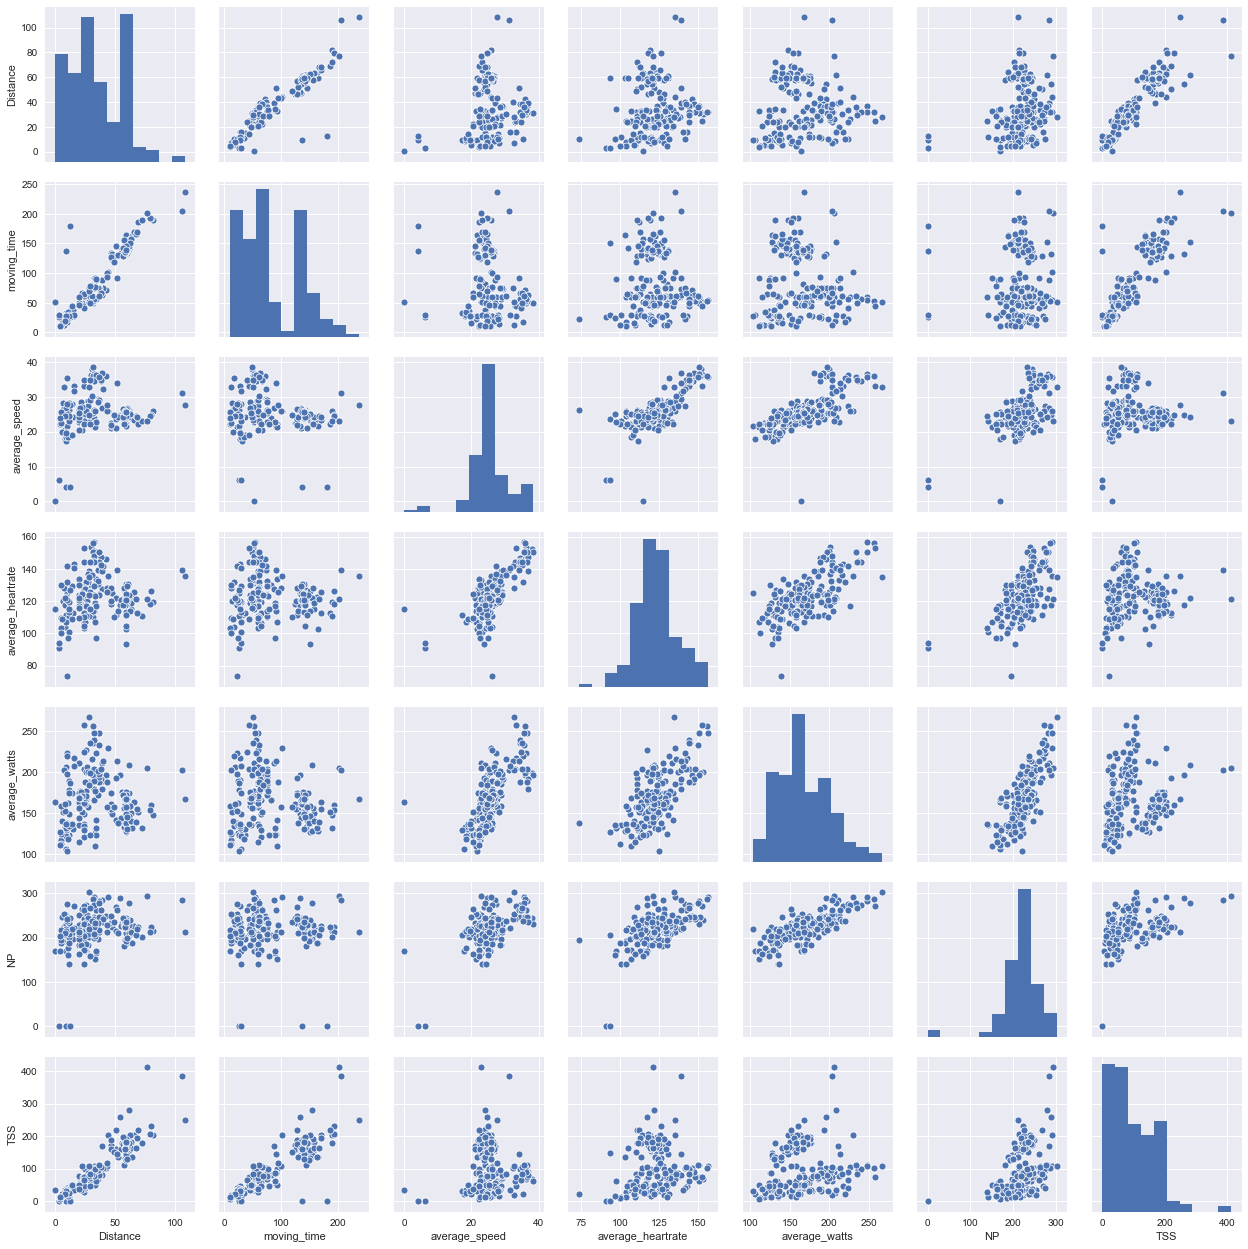

In [381]:
sns.pairplot(data=df)

This scatterplot matrix shows the relations between every variables and overall confirm all we said before with the correlation matrix. In fact, distance and moving time have a positive linear relation and a regression analysis would suite for this situation for predicting purposes.
Variables such as distance and average_heartrate do not show any linear relation and therefore a regression model would not be suidtable in this case.

Another observation can be made in terms of outliers. Scatterplots are in fact a good tool to identify some suspicious behaviour. For instance, NP has some values equal to zero that sit far away from the rest of the distribution. These values should be analyze with an expert to see whether they are anomalous or not. 

4)  We want to explore the differences between the three categories: `Race`, `Workout` and `Ride`.
    * Use scatter plots with different colours for each category to explore how these categories differ.  
    * Use histograms or box plots to visualise the different distributions of a variable for the three categories.
    * In both cases, experiment with different variables but only include those that are interesting in your final notebook (if none are interesting, show us a representative example).

First at all, let us see the distribution of frequency for the variable 'workout_type' which is a categorical variable with the following categories: Race, Workout and Ride .

In [382]:
df.groupby('workout_type').size()

workout_type
Race        29
Ride       155
Workout     25
dtype: int64

Around 75% of the times the ciclyst decided to go for a regular ride, 14% of the time the ciclyst partecipated to official races while the rest of the times involved workout.  

Text(0.5, 1.0, 'Distance travelled with workout type')

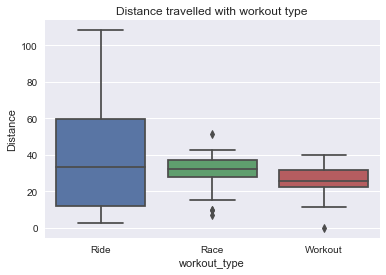

In [383]:
ax = sns.boxplot(x="workout_type", y="Distance", data=df)
plt.title('Distance travelled with workout type')

This comparative boxplot shows the distance travelled by the cyclist according to the workout type. The median distance (table below) travelled when Race and Ride are the types is longer than workout type. This can be explained by the fact that the workout sessions are meant to be shorter but more intense.
The variability of distances travelled when the cyclist rides is larger than the other two scenarios.This is visible by looking the width of the box. 
The shape of distributions is really different in this three cases. The distribution of distance ('Ride') is right skewed which means that most of the distances are relatively short, and only a few rides are long. On the other hand, the distribution of distance ('Workout') seems to be quite simmetric


In [340]:
df[['workout_type','Distance']].groupby('workout_type').median()

,Distance
workout_type,
Race,32.0802
Ride,33.1099
Workout,25.7363


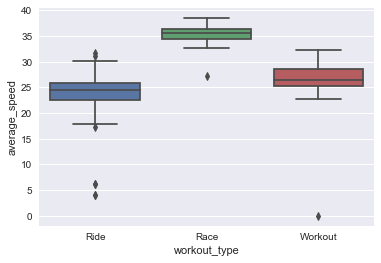

In [341]:
ax = sns.boxplot(x="workout_type", y="average_speed", data=df)
plt.title('Average speed with type of workout')

This comparative boxplot shows the average speed travelled by the cyclist according to the workout type.Immediatedly we can notice how the median speed of the cyclist is much higher when there is a race involved. In addition, the speed during races is quite consistent and do not vary a lot.

Text(0.5, 1.0, 'Power in relation to heartrate')

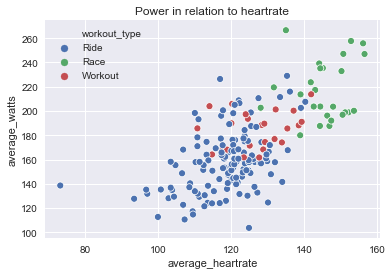

In [349]:
ax = sns.scatterplot(x="average_heartrate", y="average_watts", hue="workout_type",data=df)
plt.title('Power in relation to heartrate')

The cyclist’s average power and heartrate shows a very good positive linear relationship. According to the scatterplot we can clearly identify 3 clusters. The 'Ride' sessions (blue color) are those where the cyclist do not use much power and therefore the average heartrate remain small.
On the other hand, at the top right corner we can identify the 'Race' rides. Those demands much more power and this leads an increase of the heartrate.
The 'Workout' rides are less easy to identify clearly, but we can say that they sit in the middle of the 2 clusters.

C1)What leads to more `kudos`? Is there anything to indicate which rides are more popular? Explore the relationship between the main variables and kudos. Show a plot and comment on any relationship you observe. 

First at all, I bring a definition of kudos directly from the Strava support website.
"Similar to liking a Facebook post or favoriting a tweet, Kudos are a quick thumbs-up you can give to your fellow athletes to congratulate them on a noteworthy activity, achievement, post, badge or challenge milestone. From your feed, you can see how many Kudos have already been given and add your own. You can also give Kudos directly from the activity page or athlete post. Once you give kudos the icon will turn orange. To see the list of athletes who have previously given kudos, click on the number next to the Kudos icon. There is currently no way to remove Kudos once they have been given. You can manage your kudos notification preferences on in your settings"

In [384]:
#adding kudos as a new variable for the reduced dataset
ds=cd[['Distance','moving_time','average_speed','average_heartrate','average_watts','NP','TSS','workout_type','kudos']]

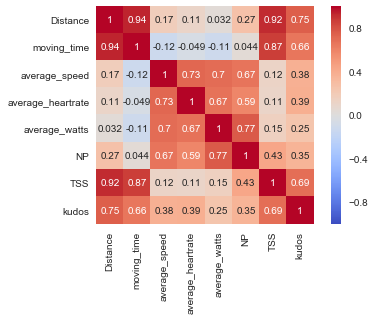

In [385]:
corrmat=ds.corr()
sns.heatmap(corrmat,vmin=-1, vmax=1, square= True,annot=True,cmap='coolwarm')

By looking at the last column of the correlation matrix we can identify 3 main factors (correlations higher than 0.65) that leads to more kudos and they are respectively to their importance Distance, moving time and TSS.
These factors are positive related to kudos, which means that for example the more distance you travel the more kudos you get.  
Since we only evaluate continuous variables as possible factors, let us see if the type of workout influences the number of kudos. A comparative boxplot is shown below.

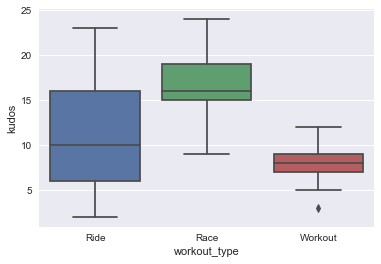

In [386]:
ax = sns.boxplot(x="workout_type", y="kudos", data=ds)

Yes, workout type is another factor to consider. In fact, 'Race' rides bring more kudos in general (the median is higher,see below). We can say that 50 % of the races done by the cyclist bring at least 16 kudos while a regular workout brings only 8 kudos.

In conclusion, workout type and distance seem to be the main factors to consider in order to get more kudos.

In [388]:
ds[['workout_type','kudos']].groupby('workout_type').median()

,kudos
workout_type,
Race,16
Ride,10
Workout,8


C2)Generate a plot that summarises the number of km ridden each month over the period of the data. Overlay this with the _sum_ of the Training Stress Score and the _average_ of the Average Speed to generate an overall summary of activity.


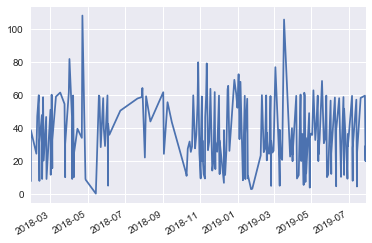

In [413]:
ds['Distance'].plot()

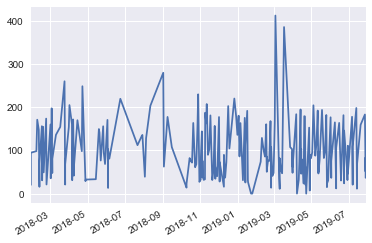

In [414]:
ds['TSS'].plot()

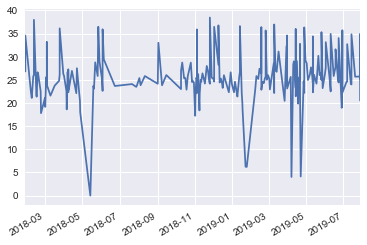

In [415]:
ds['average_speed'].plot()

## Challenge


* Generate a similar graph but one that shows the activity over a given month, with the sum of the values for each day of the month shown.  So, if there are two rides on a given day, the graph should show the sum of the distances etc for these rides.

Hint: to generate these summary plots you need to use the [timeseries/date functionality](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html) in Pandas to generate a new data frame containing the required data.  

__Note:__ once you have completed these steps you can remove this cell.  Use the text as a starting point for the documentation of your workflow and discussion of results.
